In [1]:
import phoebe
from spice.models.binary import Binary
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_transform import transform
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
from phoebe.parameters.dataset import _mesh_columns
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [2]:
from spice.models.mesh_view import get_mesh_view


def default_icosphere(model_mass=1., model_radius=1.):
    return get_mesh_view(IcosphereModel.construct(1000, model_radius, model_mass, [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))
body1 = default_icosphere()

body2 = transform(default_icosphere(0.75, 0.75), jnp.array([0., 1., 0.]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:227: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:227: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [3]:
from spice.models.mesh_view import Grid


grid = Grid.construct(body1, body2, 10)

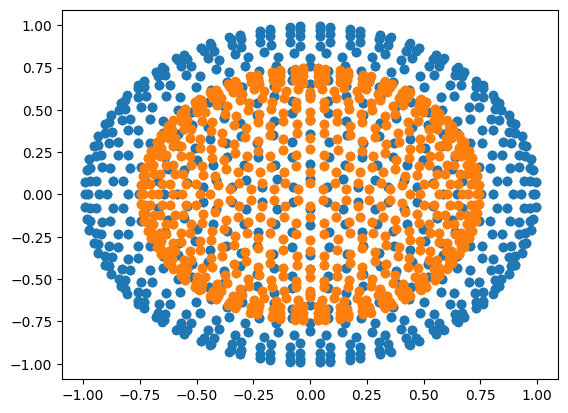

In [4]:
import matplotlib.pyplot as plt

plt.plot(body1.centers[:, 0], body1.centers[:, 2], 'o')
plt.plot(body2.centers[:, 0], body2.centers[:, 2], 'o')

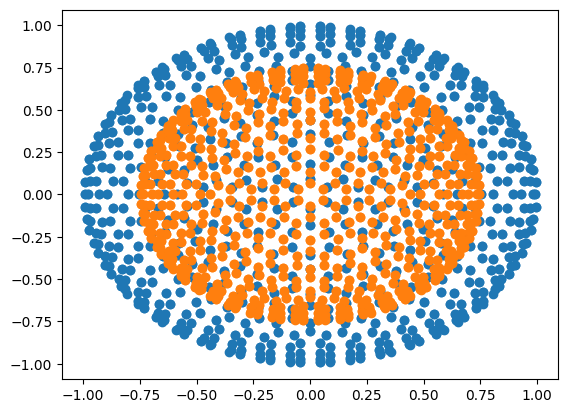

In [5]:
plt.plot(body1.cast_centers[:, 0], body1.cast_centers[:, 2], 'o')
plt.plot(body2.cast_centers[:, 0], body2.cast_centers[:, 2], 'o')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


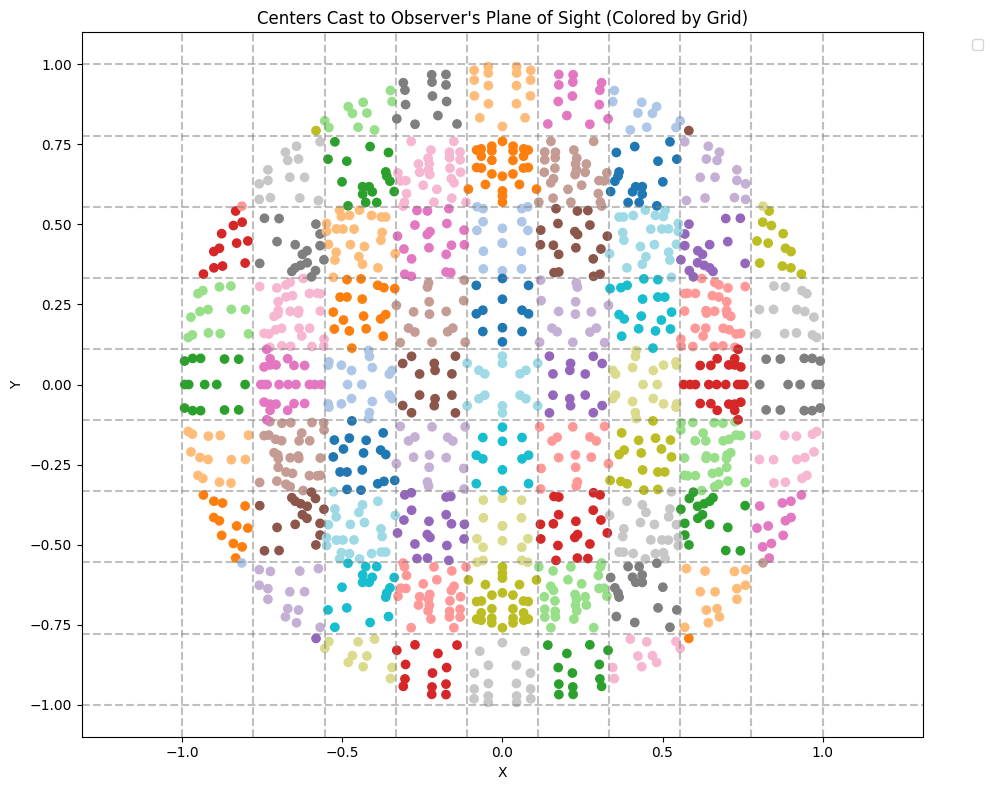

In [6]:
from functools import partial
import jax
from spice.geometry.utils import append_value_to_last_nan
from spice.models.mesh_model import MeshModel
from spice.models.mesh_view import create_grid_dictionaries, get_grid_index, get_neighbouring, total_visible_area
from spice.models.utils import cast_to_normal_plane
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Create grid dictionaries
(_, grids_m1, reverse_grids_m1), (_, grids_m2, reverse_grids_m2) = create_grid_dictionaries(body1, body2, grid)
reverse_grids_m1 = jnp.nan_to_num(reverse_grids_m1, -1)
reverse_grids_m2 = jnp.nan_to_num(reverse_grids_m2, -1)
# Create a colormap
# Create a colormap for the categories in reverse_grids_m1 and reverse_grids_m2
# Convert pairs of numbers to tuples for unique categories
unique_categories = np.unique(np.vstack((reverse_grids_m1, reverse_grids_m2)), axis=0)
n_categories = len(unique_categories)
cmap = plt.get_cmap('tab20')
category_colors = {tuple(cat): cmap(i % 20) for i, cat in enumerate(unique_categories)}

# Plot the cast centers with colors based on grid allocation
plt.figure(figsize=(10, 8))

mus1 = body1.mus > 0
plt.scatter(body1.cast_centers[mus1, 0], body1.cast_centers[mus1, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m1[mus1]])

mus2 = body2.mus > 0
plt.scatter(body2.cast_centers[mus2, 0], body2.cast_centers[mus2, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m2[mus2]])
    
for x in grid.x:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in grid.y:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Centers Cast to Observer\'s Plane of Sight (Colored by Grid)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [7]:
from spice.models.mesh_view import resolve_occlusion


body1_occluded = resolve_occlusion(body1, body2, grid)

In [8]:
jnp.max(body1_occluded.occluded_areas)

Array(0.01096571, dtype=float32)

In [9]:
jnp.max(body1_occluded.cast_areas)

Array(0.01096569, dtype=float32)

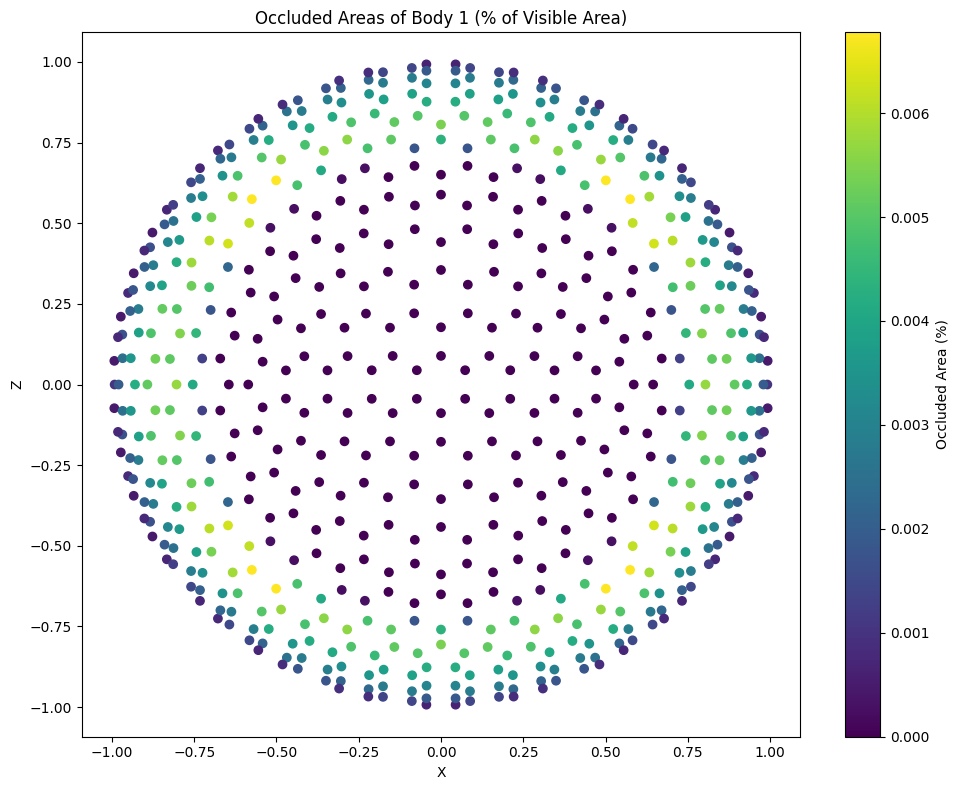

In [10]:
# Plot occluded areas as a percentage for body1
plt.figure(figsize=(10, 8))
b_mu = body1_occluded.mus > 0
plt.scatter(body1_occluded.centers[b_mu, 0], body1_occluded.centers[b_mu, 2], c=body1_occluded.cast_areas[b_mu], cmap='viridis')
plt.colorbar(label='Occluded Area (%)')
plt.title('Occluded Areas of Body 1 (% of Visible Area)')
plt.xlabel('X')
plt.ylabel('Z')
plt.tight_layout()
plt.show()


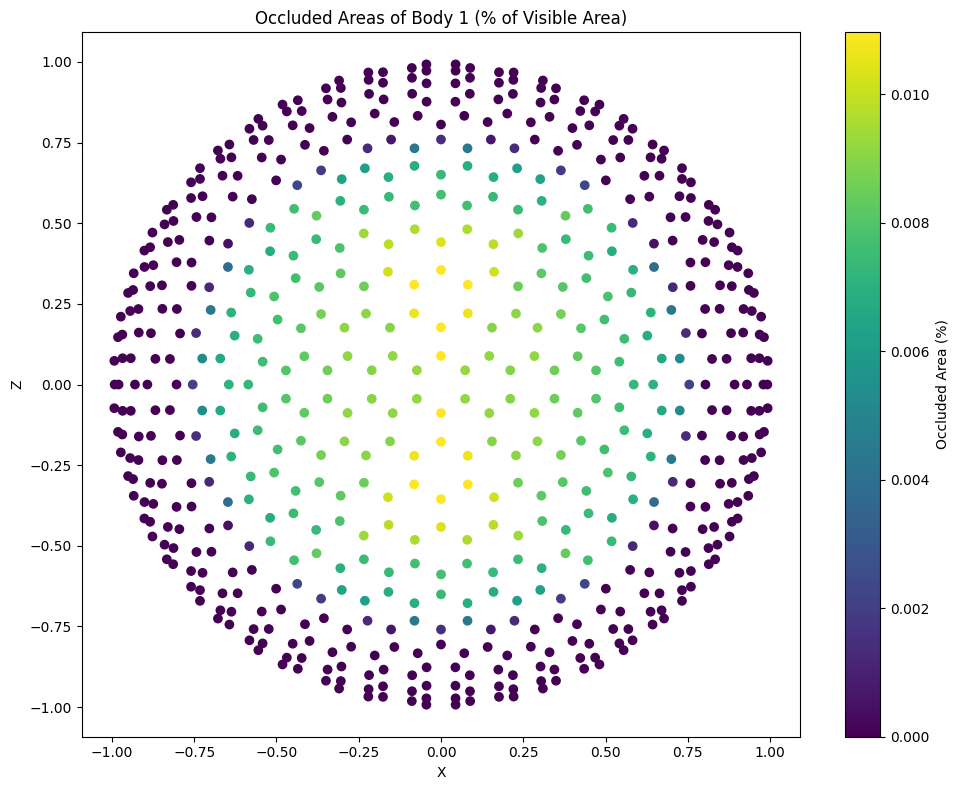

In [11]:
# Plot occluded areas as a percentage for body1
plt.figure(figsize=(10, 8))
b_mu = body1_occluded.mus > 0
plt.scatter(body1_occluded.centers[b_mu, 0], body1_occluded.centers[b_mu, 2], c=body1_occluded.occluded_areas[b_mu], cmap='viridis')
plt.colorbar(label='Occluded Area (%)')
plt.title('Occluded Areas of Body 1 (% of Visible Area)')
plt.xlabel('X')
plt.ylabel('Z')
plt.tight_layout()
plt.show()

Test 1 - Overlapping triangles intersection shape: (12, 2)
Test 1 - Non-nan points: 12

Test 2 - Non-overlapping triangles intersection shape: (12, 2)
Test 2 - Non-nan points: 0

Test 3 - Nested triangles intersection shape: (12, 2)
Test 3 - Non-nan points: 12


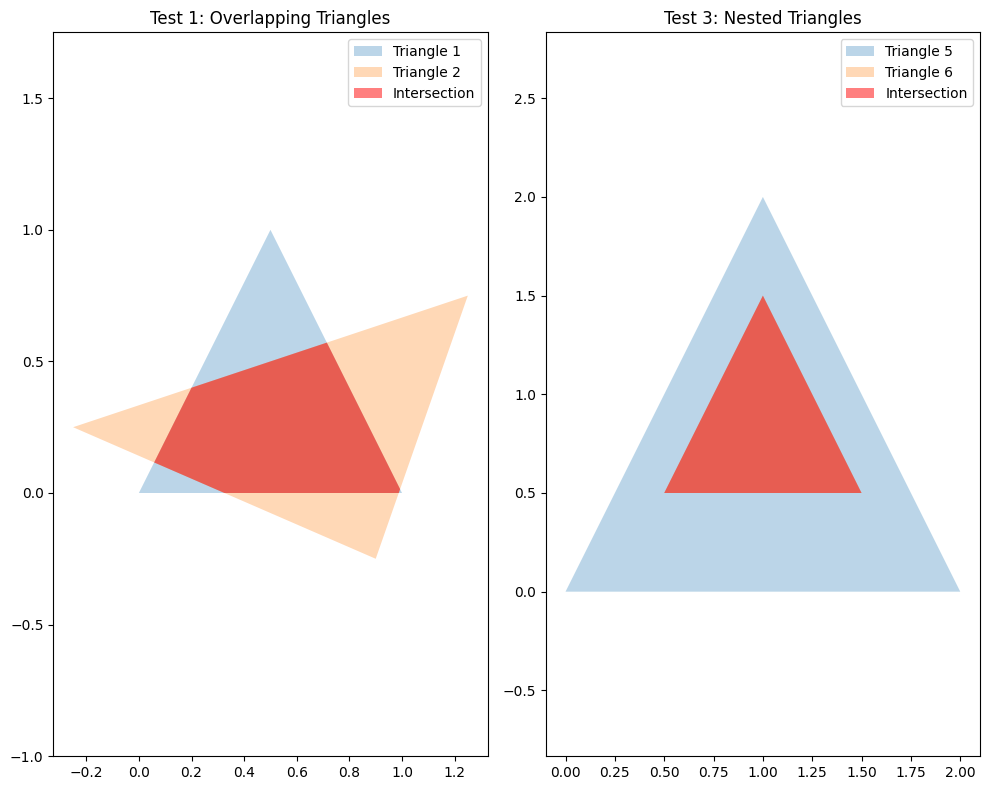

In [12]:
# Test cases for sutherland_hodgman.clip()
from spice.geometry.sutherland_hodgman import clip
import jax.numpy as jnp

# Test 1: Two overlapping triangles
triangle1 = jnp.array([[0., 0.], [1., 0.], [0.5, 1.]])
triangle2 = jnp.array([[-0.25, 0.25], [0.9, -0.25], [1.25, 0.75]])
intersection1 = clip(triangle1, triangle2)
print("Test 1 - Overlapping triangles intersection shape:", intersection1.shape)
print("Test 1 - Non-nan points:", jnp.sum(~jnp.isnan(intersection1[:, 0])))

# Test 2: Non-overlapping triangles 
triangle3 = jnp.array([[0., 0.], [1., 0.], [0.5, 1.]])
triangle4 = jnp.array([[2., 2.], [3., 2.], [2.5, 3.]])
intersection2 = clip(triangle3, triangle4)
print("\nTest 2 - Non-overlapping triangles intersection shape:", intersection2.shape)
print("Test 2 - Non-nan points:", jnp.sum(~jnp.isnan(intersection2[:, 0])))

# Test 3: One triangle completely inside another
triangle5 = jnp.array([[0., 0.], [2., 0.], [1., 2.]])
triangle6 = jnp.array([[0.5, 0.5], [1.5, 0.5], [1., 1.5]])
intersection3 = clip(triangle5, triangle6)
print("\nTest 3 - Nested triangles intersection shape:", intersection3.shape)
print("Test 3 - Non-nan points:", jnp.sum(~jnp.isnan(intersection3[:, 0])))

# Visualize test case 1
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.fill(triangle1[:, 0], triangle1[:, 1], alpha=0.3, label='Triangle 1')
plt.fill(triangle2[:, 0], triangle2[:, 1], alpha=0.3, label='Triangle 2')
valid_points = ~jnp.isnan(intersection1[:, 0])
plt.fill(intersection1[valid_points, 0], intersection1[valid_points, 1], 'r', alpha=0.5, label='Intersection')
plt.legend()
plt.title('Test 1: Overlapping Triangles')
plt.axis('equal')

# Visualize test case 3
plt.subplot(122)
plt.fill(triangle5[:, 0], triangle5[:, 1], alpha=0.3, label='Triangle 5')
plt.fill(triangle6[:, 0], triangle6[:, 1], alpha=0.3, label='Triangle 6')
valid_points = ~jnp.isnan(intersection3[:, 0])
plt.fill(intersection3[valid_points, 0], intersection3[valid_points, 1], 'r', alpha=0.5, label='Intersection')
plt.legend()
plt.title('Test 3: Nested Triangles')
plt.axis('equal')
plt.tight_layout()
plt.show()



Testing polygon_area function:
Area of simple triangle: 0.5
Area of square: 1.0
Area of rectangle: 2.0


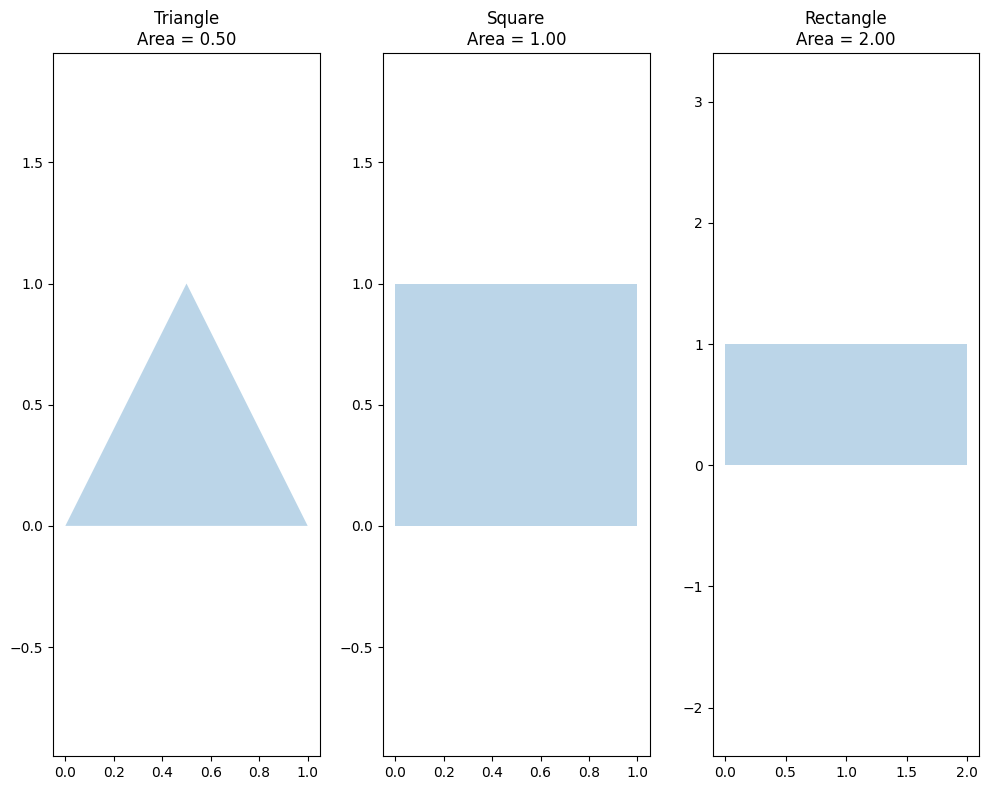

In [13]:
# Test polygon_area function from utils.py
from spice.geometry.utils import polygon_area


print("\nTesting polygon_area function:")

# Test case 1: Simple triangle
triangle = jnp.array([[0., 0.], [1., 0.], [0.5, 1.]])
area0 = polygon_area(triangle[:, 0], triangle[:, 1])
print(f"Area of simple triangle: {area0}")
# Expected area = 0.5 * base * height = 0.5 * 1 * 1 = 0.5

# Test case 2: Square
square = jnp.array([[0., 0.], [1., 0.], [1., 1.], [0., 1.]])
area1 = polygon_area(square[:, 0], square[:, 1])
print(f"Area of square: {area1}")
# Expected area = 1.0

# Test case 3: Rectangle
rectangle = jnp.array([[0., 0.], [2., 0.], [2., 1.], [0., 1.]])
area2 = polygon_area(rectangle[:, 0], rectangle[:, 1])
print(f"Area of rectangle: {area2}")
# Expected area = 2.0

# Visualize the test polygons
plt.figure(figsize=(10, 8))
plt.subplot(131)
plt.fill(triangle[:, 0], triangle[:, 1], alpha=0.3)
plt.title(f'Triangle\nArea = {area0:.2f}')
plt.axis('equal')

plt.subplot(132)
plt.fill(square[:, 0], square[:, 1], alpha=0.3)
plt.title(f'Square\nArea = {area1:.2f}')
plt.axis('equal')

plt.subplot(133)
plt.fill(rectangle[:, 0], rectangle[:, 1], alpha=0.3)
plt.title(f'Rectangle\nArea = {area2:.2f}')
plt.axis('equal')

plt.tight_layout()
plt.show()
